In [1]:
%load_ext autoreload
%autoreload 2

import os

img_dir = "img/ridge/"
if not os.path.isdir(img_dir):
    os.makedirs(img_dir)

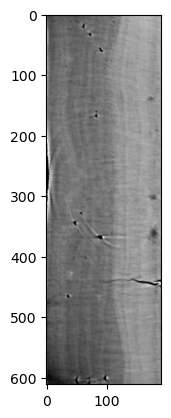

In [2]:
"""
Read in a straightened image

"""
import numpy as np
import matplotlib.pyplot as plt

image = np.load("cropped_image.npy")
plt.imshow(image, cmap="grey")

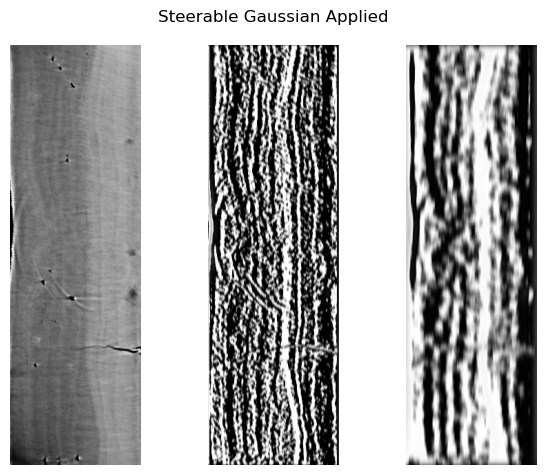

In [3]:
"""
Apply Gaussian filters

"""
from cementum import filter
from skimage import filters

sigma = 1.5
filtered = filter.steerable_filter(image, theta=0, sigma=sigma)
wide_filtered = filter.steerable_filter(image, theta=0, sigma=3 * sigma)

images = [image, filtered, wide_filtered]

# Blur the images a bit since edge detection is sensitive to noise
blur_sigma = 5
images[1:] = [filters.gaussian(img, sigma=blur_sigma) for img in images[1:]]

fig, axes = plt.subplots(1, 3)
axes[0].imshow(image, cmap="grey")
axes[1].imshow(filtered, cmap="grey")
axes[2].imshow(wide_filtered, cmap="grey")

for axis in axes:
    axis.set_axis_off()
fig.suptitle("Steerable Gaussian Applied")

fig.tight_layout()

fig.savefig(f"{img_dir}/filtered.png", bbox_inches="tight")

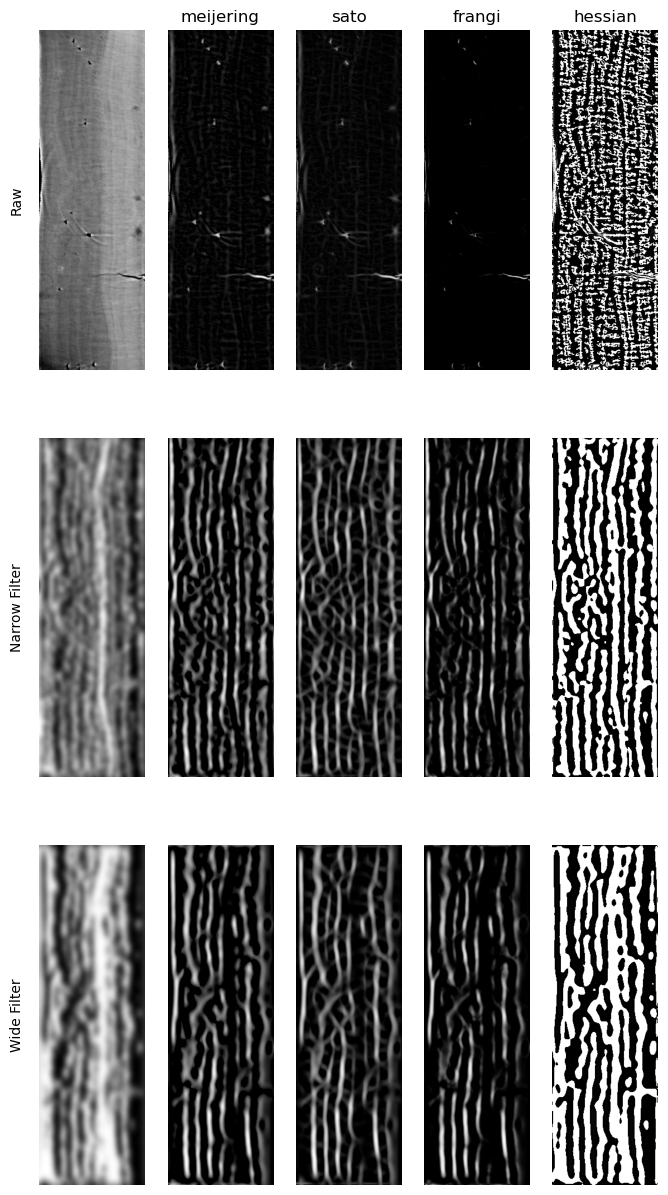

In [4]:
"""
Try several ridge detection methods

"""
from skimage import io, filters, color

# Display the original image and the detected ridges
fig, axes = plt.subplots(3, 5, figsize=(8, 15))

# Instead of turning the whole axis off, because we want to keep the label
for axis in axes.flat:
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.spines["bottom"].set_visible(False)
    axis.spines["left"].set_visible(False)
    axis.yaxis.tick_left()
    axis.xaxis.tick_bottom()
    axis.tick_params(which="both", width=0)
    axis.set_xticklabels([])
    axis.set_yticklabels([])

# Display the images
for image, axis, label in zip(
    images, axes[:, 0], ["Raw", "Narrow Filter", "Wide Filter"]
):
    axis.imshow(image, cmap="gray")
    axis.set_ylabel(label)
    axis.yaxis.label.set_visible(True)

# Display the results from ridge detection
algorithms = ["meijering", "sato", "frangi", "hessian"]
for image, axs in zip(images, axes[:, 1:]):
    for axis, algorithm in zip(axs, algorithms):
        axis.imshow(
            getattr(filters, algorithm)(image, sigmas=range(1, 5, 2)), cmap="gray"
        )

# Add labels
for label, axis in zip(algorithms, axes[0, 1:]):
    axis.set_title(label)

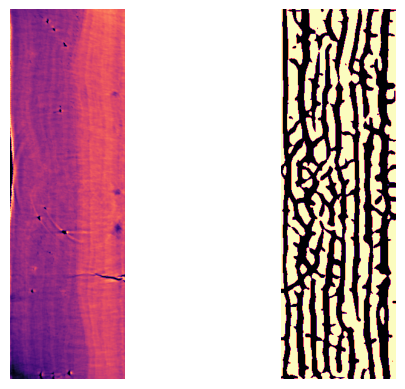

In [5]:
"""
Let's go with the Sato algorithm and narrow filter for now

"""
fig, axes = plt.subplots(1, 2)

sigma = 1.5
blur_sigma = 5
ridge_threshold = 3.0

raw = np.load("cropped_image.npy")
image = filter.steerable_filter(raw, theta=0, sigma=sigma)
image = filters.gaussian(image, sigma=blur_sigma)

ridges = filters.sato(image, sigmas=range(1, 5, 2))
is_ridge = ridges > ridge_threshold
image[is_ridge] = 0
image[~is_ridge] = 255

axes[0].imshow(raw, cmap="magma")
axes[1].imshow(image, cmap="magma")
for axis in axes:
    axis.axis("off")

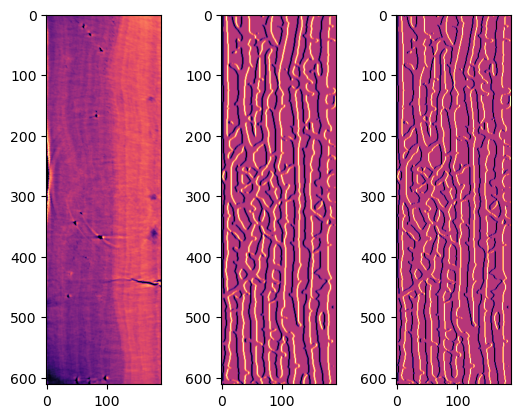

In [6]:
from skimage.filters import farid_v, scharr_v

fig, axes = plt.subplots(1, 3)
axes[0].imshow(raw, cmap="magma")
axes[1].imshow(farid_v(image), cmap="magma")
axes[2].imshow(scharr_v(image), cmap="magma")

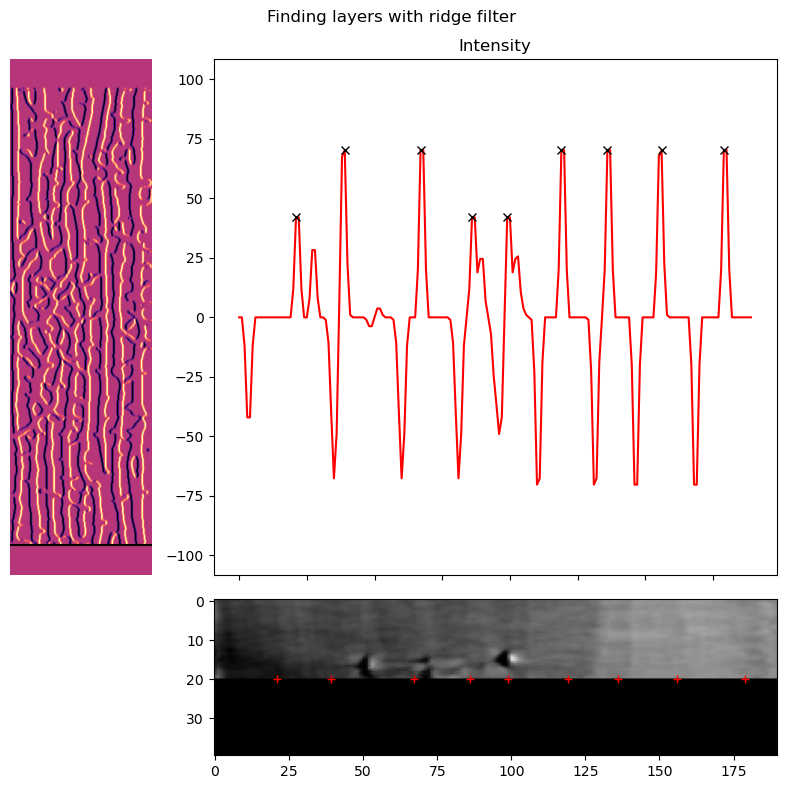

In [7]:
"""
Plot an animation stepping through the slices

"""
from scipy.signal import find_peaks
from matplotlib.animation import FuncAnimation

# Params
n_pad = 40
peak_params = {"height": 35}

# Pad with zeros top and bottom
padded_image = np.pad(image, ((n_pad, n_pad), (0, 0)), mode="constant")
padded_raw = np.pad(raw, ((n_pad, n_pad), (0, 0)), mode="constant")

ridges = farid_v(padded_image)

# Create a grid of x, y coordinates
x = np.arange(ridges.shape[1])

# Create a new figure
fig, axes = plt.subplot_mosaic(
    """
    ABBB
    ABBB
    ABBB
    .CCC
    """,
    figsize=(8, 8),
)

img_axis, profile_axis, slice_axis = (axes[l] for l in "ABC")

# Plot the ridges and a horizontal line
img_axis.imshow(ridges, cmap="magma")
hline = img_axis.axhline(n_pad, color="k")

# Plot the ridge profile
(profile,) = profile_axis.plot(x, ridges[n_pad, :], color="r")
profile_axis.set_ylim(np.min(ridges) * 1.1, np.max(ridges) * 1.1)

# Show the current slice
slice_img = slice_axis.imshow(
    padded_raw[0:n_pad],
    cmap="gray",
    aspect="auto",
    vmin=0,
    vmax=255,
)

# For indicating the peaks
peaks = find_peaks(ridges[n_pad], **peak_params)[0]
(peak_line,) = profile_axis.plot(peaks, ridges[0, peaks], "x", color="k")

# Indicate the peaks on the slice image
(layer_locations,) = slice_axis.plot(
    peaks, np.ones_like(peaks) * n_pad / 2, "+", color="r"
)


# Animation function
def update(i):
    hline.set_ydata([i, i])
    profile.set_ydata(ridges[i, :])

    peaks = find_peaks(ridges[i], **peak_params)[0]
    peak_line.set_data(peaks, ridges[i, peaks])

    slice_img.set_array(padded_raw[i - n_pad : i + n_pad])

    layer_locations.set_data(peaks, np.ones_like(peaks) * n_pad / 2)

    return hline, profile, peak_line, slice_img, layer_locations


anim = FuncAnimation(
    fig,
    update,
    frames=np.arange(n_pad, ridges.shape[0] - n_pad, step=5),
    interval=64,
    blit=True,
)

img_axis.axis("off")

profile_axis.set_xticklabels([])
profile_axis.set_title("Intensity")

fig.suptitle("Finding layers with ridge filter")
fig.tight_layout()

anim.save(f"{img_dir}/ridge_animation.mp4")

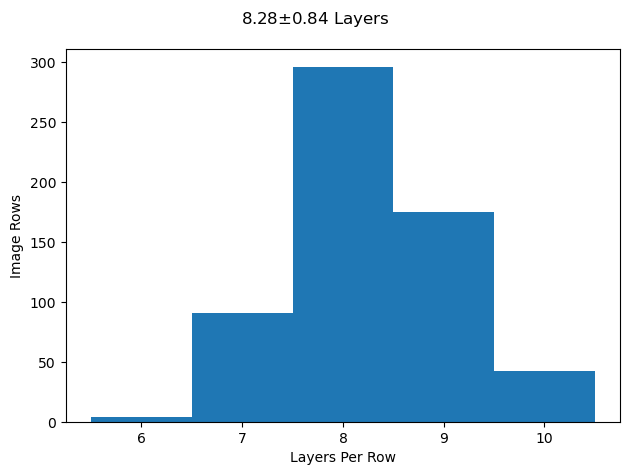

In [8]:
"""
Make a histogram of peak counts per slice

"""
n_layers = []
for row in farid_v(image):
    # Count peaks
    n_peaks = find_peaks(row, **peak_params)[0].size

    # Add to list
    n_layers.append(n_peaks)

n_layers = np.array(n_layers)

fig, ax = plt.subplots()
ax.hist(n_layers, bins=np.arange(np.min(n_layers), np.max(n_layers) + 1) - 0.5)

fig.suptitle(rf"{np.mean(n_layers):.2f}$\pm${np.std(n_layers):.2f} Layers")
ax.set_ylabel("Image Rows")
ax.set_xlabel("Layers Per Row")

fig.tight_layout()
fig.savefig(f"{img_dir}/layer_histogram.png")

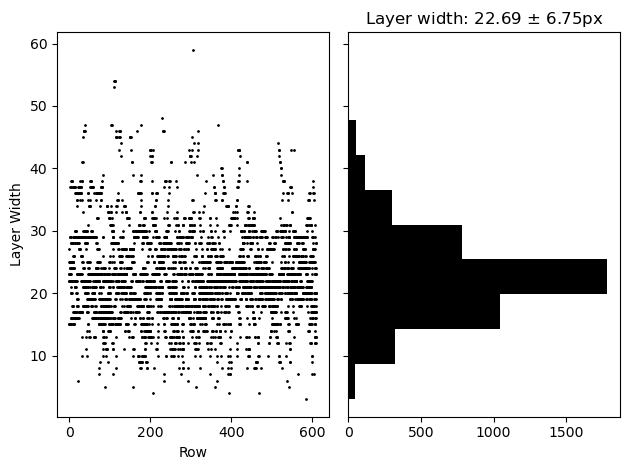

In [9]:
"""
Measure layer widths

"""
layer_widths = []

fig, axes = plt.subplots(1, 2, sharey=True)

for i, row in enumerate(farid_v(image)):
    # Count peaks
    widths = np.diff(find_peaks(row, **peak_params)[0])

    # Add to list
    layer_widths.append(widths)

    axes[0].scatter([i] * len(widths), widths, s=1, color="k")


axes[0].set_xlabel("Row")
axes[0].set_ylabel("Layer Width")

widths = np.concatenate(layer_widths)
axes[1].hist(widths, orientation="horizontal", color="k")
axes[1].set_title(f"Layer width: {np.mean(widths):.2f} $\pm$ {np.std(widths):.2f}px")

fig.tight_layout()
fig.savefig(f"{img_dir}/layer_widths.png")